In [1]:
# Import libraries
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.feature_selection as skf
from sklearn.cluster import DBSCAN
import numpy as np
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
from lassonet import LassoNetRegressor, LassoNetRegressorCV
import os
import pandas as pd
import pickle
from torch.optim import SGD, Adam
from functools import partial
import torch
import torch.nn.functional as F
import traceback
from scipy import stats
import warnings
from sklearn.exceptions import ConvergenceWarning

Skipping torch import


In [2]:
# Augment with CHH data
X0_gt = np.load('/data/Ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
df = pd.read_csv('/data/Ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]
n_rois = 6
# Data
s_directory = open('/data/Ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# Load
with open('/data/Ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
    segs = pickle.load(fp)
    n_cases = len(segs)
with open('/data/Ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
    qsms = pickle.load(fp)
with open('/data/Ali/RadDBS-QSM/data/phi/chh/_ts/Phi_mcl_gt_roi_chh', "rb") as fp:  
    Phi_gt = pickle.load(fp)
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][-2:])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)                             
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 
post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 

per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
pre_updrs_off = pre_updrs_iii_off
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)
X_all_c = X_all_c[:,0:4,:]

lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/pre_updrs_iii_off
pre_imp = lct_change
# X_all_c = X_all_c.reshape(X_all_c.shape[0],z-1)
# X_all_c = np.append(X_all_c,pre_imp.reshape(-1,1),axis=1)
subsc = subject_id_corr
subs_init = subsc

/tmp/ipykernel_1856/3066526659.py:24: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  subject_id_corr = subject_id[np.in1d(subject_id,case_number)]


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000001 for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000002 for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000003 for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000004 for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000005 for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000006 for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000007 for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000008 for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000009 for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000010 for case 10.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000011 for case 11.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segm

/tmp/ipykernel_1856/3066526659.py:30: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)
/tmp/ipykernel_1856/3066526659.py:31: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)
/tmp/ipykernel_1856/3066526659.py:32: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)


In [3]:
# # Training parameters
# scoring = 'r2'
# results_bls = np.zeros_like(per_change)
# results_ls = np.zeros_like(per_change)
# scaler = skp.StandardScaler()
# #X = X_all_c.astype(float)#scaler.fit_transform(np.asarray(X_all_c,dtype=float).reshape(X_all_c.shape[0],-1))
# epsilon = 1e-1
# ledd = np.zeros_like(per_change)
# cvn = 6
# # Train
# for j in np.arange(len(subsc)):
#     test_id = subsc[j]
#     test_index = subsc == test_id
#     train_index = subsc != test_id
#     X_train = X_all_c[train_index,:,:]
#     X_test = X_all_c[test_index,:,:]
#     y_train = per_change[train_index]
#     y_test = per_change[test_index]
#     # Try this with common scaling
#     X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
#                                                 X_train,train_index,X_test,
#                                                 test_index,pre_updrs_off,ledd,None,None,None,None,None,None,None,None,False,False,False)
#     with np.errstate(divide='ignore', invalid='ignore'):
#       # Feature selection
#       sel = skf.SelectKBest(skf.r_regression,k='all')
#       X0_ss = sel.fit_transform(X0_ss0,y_train)
#       X_test_ss = sel.transform(X_test_ss0)
#       y_n = cKDTree(X0_ss).query(X_test_ss, k=1)[1]
    
#       Xy = np.dot(X0_ss.T,y_train)
#     if Xy.ndim == 1:
#         Xy = Xy[:, np.newaxis]
#     alpha_max = np.sqrt(np.sum(Xy**2, axis=1)).max()/len(y_train) 
#     alphas = np.linspace(alpha_max*1e-3,alpha_max,10)
#     # LASSO
#     lasso = slm.LassoCV(max_iter=int(1e5),n_jobs=-1,cv=cvn,alphas=alphas,random_state=0)
#     est_ls = lasso.fit(X0_ss,y_train)
#     print('LassoCV score:',est_ls.score(X0_ss,y_train))
#     results_ls[j] = est_ls.predict(X_test_ss).item()
#     print('Lasso predicts',str(np.round(results_ls[j],2)),
#           'with regularization',str(np.round(est_ls.alpha_,5)))
#     # LASSONet
#     lr=1e-3 # NOT ACTUALLY PASSING
#     lassonet = LassoNetRegressorCV(
#     cv=cvn,
#     M=1e-16, # Approximate standard LASSO
#     batch_size=len(y_train), # Leads to gradient descent optimization
#     hidden_dims=(5,), #CHANGE
#     #n_iters=(int(1e4),int(1e2)), # Iterations for objective function and path
#     tol=0.99,#1-est_ls.tol,  
#     lambda_seq=alphas, # Path multipler and initial lambda disregarded
#     optim=partial(SGD,lr=lr,momentum=0.9), # Approximate coordinate descent
#     #backtrack=True, # Approximate monotonic coordinate descent path
#     verbose=1,
#     torch_seed=0,
#     random_state=0,
#     gamma=0.0, # No L2 regularization
#     gamma_skip=0.0, # No L2 regularization on skip connection
#     patience=None, # Disable early stopping
#     val_size=0.1,
#     )
#     # What should these norms be...besides nonzero?
#     est_lsn = lassonet.fit(X0_ss,y_train)
  
#     print('LassoNetCV score:',est_lsn.score(X0_ss,y_train))
#     results_bls[j] = est_lsn.predict(X_test_ss).item()

#     # Training status
#     print('Lasso predicts',str(np.round(results_ls[j],2)),
#           'with regularization',str(np.round(est_ls.alpha_,5)),
#           'and',str(np.sum(est_ls.coef_!=0)),'nonzero coefficients',
#           'and LassoNet predicts',str(np.round(results_bls[j],2)),
#           'for case',str(int(subsc[j])),'with',str(np.round(per_change[j],2)))



In [4]:
# Noise compensated LASSO
retrain = 1
results_bls = np.zeros_like(per_change)
K_nz_nc = []
K_nz_nc_lr = []
E_nz_nc = []
E_nz_nc_lr = []
R_nz_cd = []
results_ls_aug = np.zeros_like(per_change)
reg = True
if retrain == 1:

  aug = True
  K_nz = []
  c = 0

  for j in np.arange(c,len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train0 = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train0 <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss00,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_iii_on,None,None,None,None,
                                                  None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn+1,1))
      cv_lgr_scores = np.zeros((cvn+1,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train0)
      kappa = stats.skew(y_train0)
      print('Label distribution of:',mu,sigma,kappa)
      Q = 10
      for jj in np.arange(Q):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss00 = np.append(X0_ss00,X0_ss00[idyr,:].reshape(1,-1),axis=0)
          y_train0 = np.append(y_train0,y_train0[idyr])
          y_cat = y_train0 <= 0.3
          rs = rs+1
          print('Resampled to size',y_train0.shape)
          y_train_n = y_train0
          X0_ss0_n = X0_ss00
        if aug == True:
          y_train_n = np.append(y_train_n,y_train0+(1.96*sigma)*np.random.normal(0,1,1))
          y_cat = y_train_n <= 0.3
          X0_ss0_n = np.append(X0_ss0_n,X0_ss00,axis=0)

      y_train = y_train_n
      X0_ss = X0_ss0_n
      
      for jj in np.arange(2,cvn+1):
        #LASSONet
        lr=1e-3 # NOT ACTUALLY PASSING
        lassonet = LassoNetRegressorCV(
        cv=jj,
        M=1e-16, # Approximate standard LASSO
        batch_size=len(y_train), # Leads to gradient descent optimization
        hidden_dims=(5,), #CHANGE
        #n_iters=(int(1e4),int(1e2)), # Iterations for objective function and path
        tol=0.99,#1-est_ls.tol,  
        #lambda_seq=alphas, # Path multipler and initial lambda disregarded
        optim=partial(SGD,lr=lr,momentum=0.9), # Approximate coordinate descent
        #backtrack=True, # Approximate monotonic coordinate descent path
        verbose=1,
        torch_seed=0,
        random_state=0,
        gamma=0.0, # No L2 regularization
        gamma_skip=0.0, # No L2 regularization on skip connection
        patience=None, # Disable early stopping
        val_size=0.1,
        )
        with warnings.catch_warnings(category=UserWarning):     
          warnings.simplefilter("ignore") 
          est_lsn = lassonet.fit(X0_ss,y_train)
        cv_scores[jj] = est_lsn.score(X0_ss,y_train)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):     
        if reg == True: 
          best_cv = np.argmax(cv_scores)
          #LASSONet
          lr=1e-3 # NOT ACTUALLY PASSING
          lassonet = LassoNetRegressorCV(
          cv=best_cv,
          M=1e-16, # Approximate standard LASSO
          batch_size=len(y_train), # Leads to gradient descent optimization
          hidden_dims=(100,), #CHANGE
          #n_iters=(int(1e4),int(1e2)), # Iterations for objective function and path
          tol=0.99,#1-est_ls.tol,  
          #lambda_seq=alphas, # Path multipler and initial lambda disregarded
          optim=partial(SGD,lr=lr,momentum=0.9), # Approximate coordinate descent
          #backtrack=True, # Approximate monotonic coordinate descent path
          verbose=1,
          torch_seed=0,
          random_state=0,
          gamma=0.0, # No L2 regularization
          gamma_skip=0.0, # No L2 regularization on skip connection
          patience=None, # Disable early stopping
          val_size=0.1,
          )
        with warnings.catch_warnings(category=UserWarning):  
          warnings.simplefilter("ignore")    
          est_lsn = lassonet.fit(X0_ss,y_train)
      print('LassoNetCV score:',est_lsn.score(X0_ss,y_train))
      results_bls[j] = est_lsn.predict(X_test_ss0).item()
      print('LassoNet predicts',str(np.round(results_bls[j],2)),'for case',str(int(subsc[j])),'with',str(np.round(per_change[j],2)))
      c = c+1

    


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [15:43<00:00, 235.88s/it]


LassoNetCV score: 0.2915414848299027
LassoNet predicts 0.79 for case 1 with 0.72
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [19:19<00:00, 231.85s/it]


LassoNetCV score: 0.29236041083797415
LassoNet predicts 0.71 for case 2 with 0.47
Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [1:06:16<00:00, 994.00s/it] 


LassoNetCV score: 0.29176333714832803
LassoNet predicts 0.9 for case 3 with 0.69
Label distribution of: 0.5752269235227969 0.2084721065940771 -0.34398027688109245
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [1:22:29<00:00, 989.84s/it] 


LassoNetCV score: 0.29344082335197896
LassoNet predicts 0.7 for case 4 with 0.42
Label distribution of: 0.5827907017222488 0.19744836811095323 -0.25025976222641483
Resampled to size (37,)
Resampled to size (38,)
Resampled to size (39,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [1:09:25<00:00, 1041.30s/it]


LassoNetCV score: 0.5610842498760389
LassoNet predicts 0.32 for case 5 with 0.15
Label distribution of: 0.5746924331750638 0.20884605172212908 -0.33822865445502964
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:46<00:00, 117.24s/it]


LassoNetCV score: 0.2921492273925267
LassoNet predicts 0.6 for case 6 with 0.44
Label distribution of: 0.5624312245980657 0.20344924934212058 -0.28703446866429055
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:57<00:00, 119.53s/it]


LassoNetCV score: 0.2924660784349904
LassoNet predicts 0.74 for case 7 with 0.88
Label distribution of: 0.5758937568978073 0.20793336707043802 -0.35000008336051325
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:39<00:00, 115.95s/it]


LassoNetCV score: 0.29368901519051327
LassoNet predicts 0.52 for case 8 with 0.4
Label distribution of: 0.5702986081106105 0.20999601422390549 -0.27751686488556404
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [10:20<00:00, 124.20s/it]


LassoNetCV score: 0.291627567720654
LassoNet predicts 0.65 for case 9 with 0.6
Label distribution of: 0.5643062245980658 0.2060398064467874 -0.25159784666703033
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:31<00:00, 114.31s/it]


LassoNetCV score: 0.2911273955777921
LassoNet predicts 0.6 for case 10 with 0.81
Label distribution of: 0.5691451725886095 0.20973322323580731 -0.2629533781637346
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:55<00:00, 119.09s/it]


LassoNetCV score: 0.29149060058891463
LassoNet predicts 0.82 for case 11 with 0.64
Label distribution of: 0.5669751715300725 0.2085993111100245 -0.24481874200363993
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [12:02<00:00, 144.51s/it]


LassoNetCV score: 0.2916958010666705
LassoNet predicts 0.7 for case 13 with 0.72
Label distribution of: 0.5783286604955017 0.20527469945818264 -0.35630765675696446
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:32<00:00, 114.42s/it]


LassoNetCV score: 0.29519131118385755
LassoNet predicts 0.72 for case 14 with 0.31
Label distribution of: 0.5679867801536214 0.20923231991769523 -0.25136542100761594
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [07:52<00:00, 118.00s/it]


LassoNetCV score: 0.2909802229847228
LassoNet predicts 0.57 for case 16 with 0.68
Label distribution of: 0.5774859976810078 0.2063190239320207 -0.3574795129443696
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [48:31<00:00, 582.37s/it]


LassoNetCV score: 0.29376557796026914
LassoNet predicts 0.43 for case 18 with 0.34
Label distribution of: 0.5705357997614644 0.21002096073970725 -0.2807677568009367
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [1:05:14<00:00, 978.73s/it]


LassoNetCV score: 0.2916005980121431
LassoNet predicts 0.56 for case 19 with 0.59
Label distribution of: 0.5607985715368413 0.2006390097129064 -0.34802680409786524
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [1:21:47<00:00, 981.59s/it] 


LassoNetCV score: 0.29327065269147123
LassoNet predicts 0.68 for case 20 with 0.94
Label distribution of: 0.5636330386570226 0.20518643494540414 -0.26076044933979126
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [07:45<00:00, 116.27s/it]


LassoNetCV score: 0.2919892025594739
LassoNet predicts 0.83 for case 21 with 0.84
Label distribution of: 0.5841874969994993 0.19415564179220104 -0.16306203646880674
Resampled to size (37,)
Resampled to size (38,)
Resampled to size (39,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:58<00:00, 119.61s/it]


LassoNetCV score: 0.5510593260240102
LassoNet predicts 0.3 for case 22 with 0.1
Label distribution of: 0.5753580538663584 0.20837251231034953 -0.34527291849868297
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:49<00:00, 117.90s/it]


LassoNetCV score: 0.29273492271022394
LassoNet predicts 0.69 for case 23 with 0.41
Label distribution of: 0.5710026531694943 0.21004110516915736 -0.28733840263675836
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:48<00:00, 117.68s/it]


LassoNetCV score: 0.29118590611564055
LassoNet predicts 0.66 for case 24 with 0.57
Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:47<00:00, 117.54s/it]


LassoNetCV score: 0.2911829706429987
LassoNet predicts 0.77 for case 25 with 0.66
Label distribution of: 0.5694255265923677 0.20981871046638942 -0.2662656536773807
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:25<00:00, 113.11s/it]


LassoNetCV score: 0.2911551426764023
LassoNet predicts 0.67 for case 26 with 0.63
Label distribution of: 0.5738037736176735 0.20935457901382964 -0.3272511581002607
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [07:39<00:00, 114.95s/it]


LassoNetCV score: 0.292264914661171
LassoNet predicts 0.77 for case 27 with 0.47
Label distribution of: 0.5790052986721398 0.2043392189714069 -0.3521164038418525
Resampled to size (37,)
Resampled to size (38,)
Resampled to size (39,)


Choosing lambda with cross-validation: 100%|██████████| 3/3 [05:58<00:00, 119.41s/it]


LassoNetCV score: 0.5609260953311684
LassoNet predicts 0.16 for case 28 with 0.28
Label distribution of: 0.5703496493519336 0.21000221972805436 -0.27821061318927803
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:23<00:00, 112.74s/it]


LassoNetCV score: 0.2912004601735606
LassoNet predicts 0.77 for case 29 with 0.59
Label distribution of: 0.572169786689569 0.20992345901172824 -0.3042853268818935
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [07:29<00:00, 112.37s/it]


LassoNetCV score: 0.2920282821242932
LassoNet predicts 0.77 for case 30 with 0.53
Label distribution of: 0.5629738602569804 0.2042678402570905 -0.27346537727473835
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:36<00:00, 115.33s/it]


LassoNetCV score: 0.29271407940848193
LassoNet predicts 0.69 for case 31 with 0.86
Label distribution of: 0.5735011834458024 0.20949562291124812 -0.3232022231648087
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:43<00:00, 116.67s/it]


LassoNetCV score: 0.2930407256449623
LassoNet predicts 0.59 for case 32 with 0.48
Label distribution of: 0.568660732794787 0.20955271665824066 -0.2576598769765803
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [10:00<00:00, 120.18s/it]


LassoNetCV score: 0.2922164809379231
LassoNet predicts 0.79 for case 33 with 0.66
Label distribution of: 0.5776164097832509 0.206166083456723 -0.3575627941827524
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:48<00:00, 117.68s/it]


LassoNetCV score: 0.2952877600705538
LassoNet predicts 0.59 for case 34 with 0.33
Label distribution of: 0.5731361230448997 0.20964415222225632 -0.31816132090731236
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:46<00:00, 117.29s/it]


LassoNetCV score: 0.2932499292958398
LassoNet predicts 0.48 for case 35 with 0.49
Label distribution of: 0.5652707307709053 0.20711530756483246 -0.2442832622694056
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [07:53<00:00, 118.31s/it]


LassoNetCV score: 0.29259070388662456
LassoNet predicts 0.77 for case 36 with 0.78
Label distribution of: 0.5644585150464088 0.20622109204736833 -0.2500116622013785
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:38<00:00, 115.61s/it]


LassoNetCV score: 0.292840513195588
LassoNet predicts 0.65 for case 37 with 0.81
Label distribution of: 0.5670343992012403 0.20864142707871972 -0.24509142715462312
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 5/5 [09:55<00:00, 119.02s/it]


LassoNetCV score: 0.29212330697993105
LassoNet predicts 0.83 for case 38 with 0.71
Label distribution of: 0.5781196303951672 0.20554616966278674 -0.356990224910928
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [07:46<00:00, 116.73s/it]


LassoNetCV score: 0.2958834088344152
LassoNet predicts 0.59 for case 39 with 0.32
Label distribution of: 0.5637275208943621 0.2053113472299323 -0.2592529006209024
Resampled to size (37,)
Resampled to size (38,)


Choosing lambda with cross-validation: 100%|██████████| 4/4 [07:42<00:00, 115.73s/it]


LassoNetCV score: 0.29255519381284123
LassoNet predicts 0.75 for case 40 with 0.83


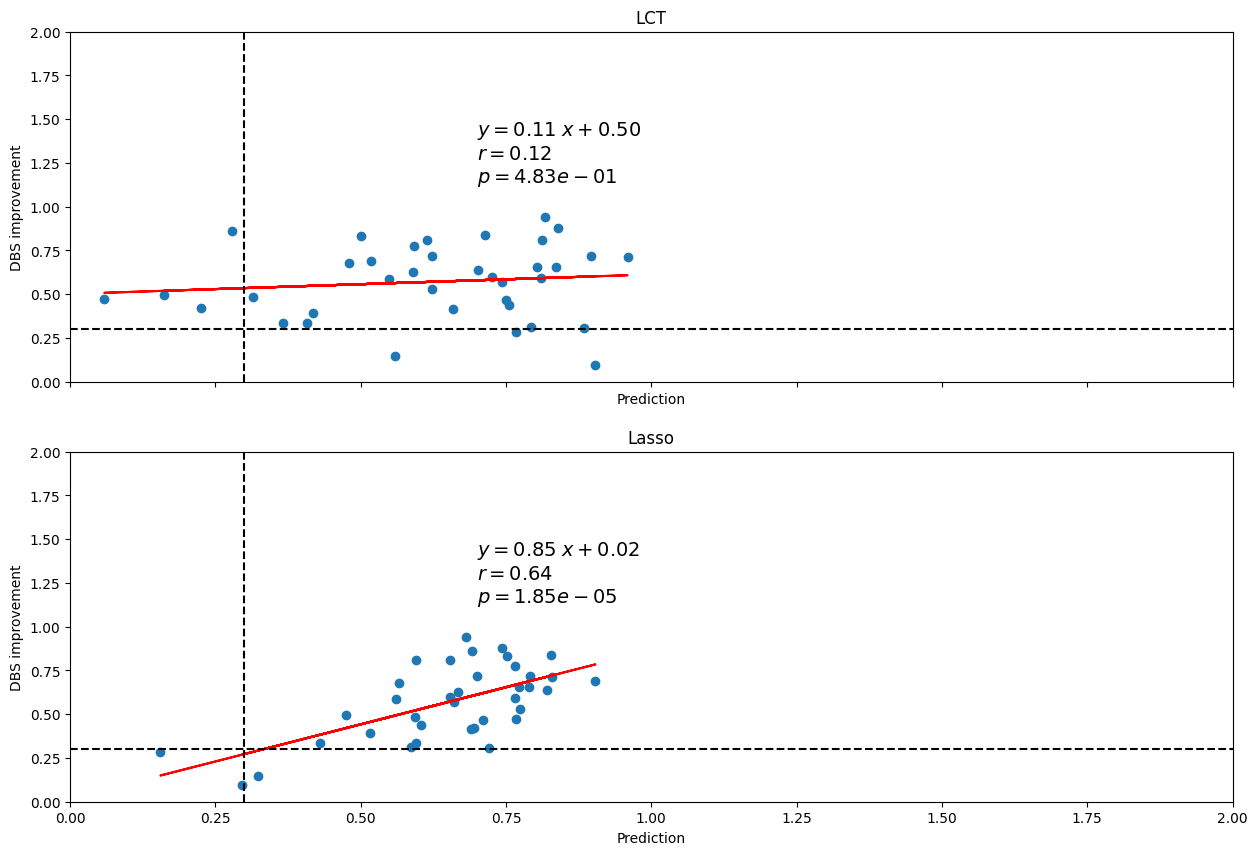

In [7]:
util.eval_prediction(np.vstack((pre_imp,
                            #    results_ls_aug,
                               results_bls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                'LassoNet'
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')



Text(0.1, 0.8, '$y=0.85\\; x+0.02$\n$r = 0.64$\n$p = 1.85e-05$')

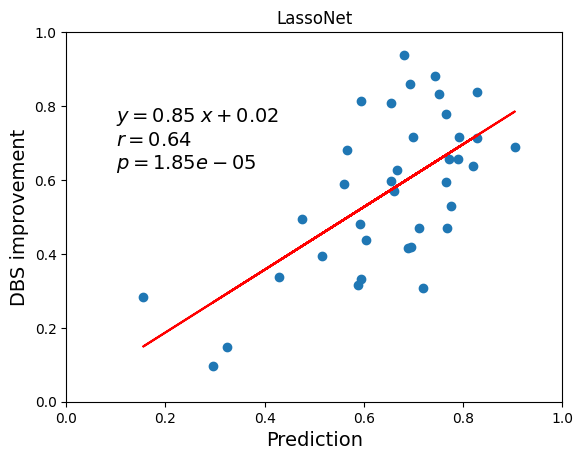

In [8]:
plt.scatter(results_bls,per_change)
lr = stats.linregress(results_bls,per_change)
plt.plot(results_bls,results_bls*lr.slope+lr.intercept,color='r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('LassoNet')
plt.ylabel("DBS improvement",fontsize=14)
plt.xlabel("Prediction",fontsize=14)
text = f"$y={lr.slope:0.2f}\; x{lr.intercept:+0.2f}$\n$r = {lr.rvalue:0.2f}$\n$p = {lr.pvalue:0.2e}$"
plt.text(0.1, 0.8, text,
    fontsize=14, verticalalignment='top')

Text(0.1, 0.8, '$y=0.11\\; x+0.50$\n$r = 0.12$\n$p = 4.83e-01$')

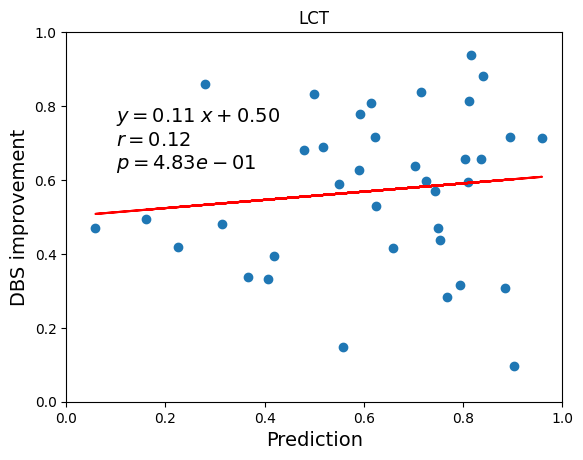

In [9]:
plt.scatter(lct_change,per_change)
lr = stats.linregress(lct_change,per_change)
plt.plot(lct_change,lct_change*lr.slope+lr.intercept,color='r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('LCT')
plt.ylabel("DBS improvement",fontsize=14)
plt.xlabel("Prediction",fontsize=14)
text = f"$y={lr.slope:0.2f}\; x{lr.intercept:+0.2f}$\n$r = {lr.rvalue:0.2f}$\n$p = {lr.pvalue:0.2e}$"
plt.text(0.1, 0.8, text,
    fontsize=14, verticalalignment='top')